## Importing Modules

In [1]:
import numpy
import pandas as pd
from shapely.geometry import Point, mapping, LineString
import numpy as np
import rasterio
from rtree import index
import json
import networkx as nx
import momepy
import geopandas as gpd
import os
import matplotlib.pyplot as plt
from cartopy import crs
import xml.etree.ElementTree as ET
import gpxpy.gpx

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\geopandas\_compat.py:110: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Preprocessing

In [2]:
sheepstor_map = rasterio.open(os.path.join('OS Explorer Maps','Download_South+Dartmoor_2004150','raster-25k_4541337','sx','sx56.tif'))

In [3]:
tree = ET.parse(os.path.join('Detailed-Path-Network','DARTMOOR NATIONAL PARK.gml'))
root = tree.getroot()
startNodes = [startNode.attrib for startNode in
              root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}startNode')]
startNodes = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in startNodes]
endNodes = [endNode.attrib for endNode in
            root.iter('{http://namespaces.os.uk/networks/detailedPathNetwork/1.0}endNode')]
endNodes = [nodes['{http://www.w3.org/1999/xlink}href'] for nodes in endNodes]
path_network = gpd.read_file(os.path.join('Detailed-Path-Network','DARTMOOR NATIONAL PARK.gml'))
path_network['startNodes'] = startNodes
path_network['endNodes'] = endNodes
path_network

,gml_id,featureID,versionID,versionDate,descriptiveGroup,descriptiveTerm,physicalLevel,rightOfUse,adoptedByNationalCycleRoute,adoptedByRecreationalRoute,...,planimetricLength,planimetricLength_uom,surfaceLength,surfaceLength_uom,surfaceType,roadNumber,name,geometry,startNodes,endNodes
0,ID_6d02367c-6835-4e6a-ab2a-8a04514fee37,6d02367c-6835-4e6a-ab2a-8a04514fee37,7,2019-08-28,Non Motorised Vehicular Route Network,No Physical Manifestation,Surface Level,Footpath,False,False,...,239.4,m,239.7,m,None,None,None,"LINESTRING Z (253338.238 73409.009 301.660, 25...",#ID_bfcd67f0-bec8-4d0b-8547-e540fa7a6655,#ID_46417a14-6ed6-4e83-9eaa-38b78b3700df
1,ID_d9093320-511e-407d-9b6f-890e62f5d6e6,d9093320-511e-407d-9b6f-890e62f5d6e6,7,2019-08-28,Non Motorised Vehicular Route Network,No Physical Manifestation,Surface Level,Footpath,False,False,...,43.4,m,43.7,m,None,None,None,"LINESTRING Z (253338.238 73409.009 301.660, 25...",#ID_bfcd67f0-bec8-4d0b-8547-e540fa7a6655,#ID_bfb31851-34a6-4e49-ad76-98b344b6b0b1
2,ID_8800555f-55ff-454f-8ef8-d3340e334421,8800555f-55ff-454f-8ef8-d3340e334421,7,2019-08-28,Non Motorised Vehicular Route Network,Path,Surface Level,None,False,False,...,67.4,m,67.4,m,Unmade,None,None,"LINESTRING Z (256086.154 63196.168 296.400, 25...",#ID_0591767d-7b29-4308-97a1-9315d6abf0e4,#ID_4923674d-37e4-4829-bfb8-c1f99a427149
3,ID_e62cede6-c92e-440e-a4fa-b3e192a00083,e62cede6-c92e-440e-a4fa-b3e192a00083,7,2019-08-28,Non Motorised Vehicular Route Network,Path,Surface Level,None,False,False,...,200.2,m,200.4,m,Unmade,None,None,"LINESTRING Z (255848.312 63152.615 301.860, 25...",#ID_059e58e5-c3f4-4f3b-8b7e-7d5d82a48462,#ID_4923674d-37e4-4829-bfb8-c1f99a427149
4,ID_0fbd7d2c-3654-49e9-a010-8dd65f6ef80a,0fbd7d2c-3654-49e9-a010-8dd65f6ef80a,7,2019-08-28,Non Motorised Vehicular Route Network,Path,Surface Level,Bridleway,False,False,...,32.8,m,32.9,m,Unmade,None,None,"LINESTRING Z (255825.760 63128.917 299.690, 25...",#ID_e2528d5e-1194-4e3d-baa9-a52ee7b6ea19,#ID_059e58e5-c3f4-4f3b-8b7e-7d5d82a48462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17249,ID_a238cf22-40a8-498b-ab72-769f2496b2a3,a238cf22-40a8-498b-ab72-769f2496b2a3,7,2019-08-28,Non Motorised Vehicular Route Network,Path,Surface Level,None,False,False,...,139.3,m,140.1,m,Unmade,None,None,"LINESTRING Z (255176.912 66568.369 237.710, 25...",#ID_09724c46-f6d6-4f2b-83a9-6e2a76982d29,#ID_3e9e23ec-16bd-4989-beba-89f848d5fabe
17250,ID_4bd08db1-433f-492d-b373-d7c6ad75100c,4bd08db1-433f-492d-b373-d7c6ad75100c,7,2019-08-28,Non Motorised Vehicular Route Network,Track,Surface Level,None,False,False,...,1150.1,m,1151.2,m,Unmade,None,None,"LINESTRING Z (265627.372 76796.393 327.000, 26...",#ID_f9bfe787-f3f7-46b0-9dd9-33b3e686163b,#ID_35ec3b55-3349-4551-9de0-dadf4eba88ef
17251,ID_dab6d3bf-f46c-427f-b848-2d8600f2d03e,dab6d3bf-f46c-427f-b848-2d8600f2d03e,7,2019-08-28,Non Motorised Vehicular Route Network,Minor Road,Surface Level,Normal Permissible Uses,False,False,...,658.3,m,660.5,m,Made Sealed,None,None,"LINESTRING Z (268990.049 88888.634 249.140, 26...",#ID_759a6531-d4a2-4dca-b9aa-d1ae144b6cbd,#ID_43fa4113-7d3f-4af0-a4bd-32327ea2acc7
17252,ID_582722ab-01f8-4425-b706-4416921896eb,582722ab-01f8-4425-b706-4416921896eb,7,2019-08-28,Non Motorised Vehicular Route Network,Path,Surface Level,None,False,False,...,315.7,m,316.7,m,Unmade,None,None,"LINESTRING Z (265675.768 87448.587 399.040, 26...",#ID_7a5199a8-aa7d-4a2f-80d2-e2c53d387959,#ID_ae0ec9c3-ff24-4d66-9224-91ec98a9771c


In [4]:
json_paths = json.load(open(os.path.join('Detailed-Path-Network','DartmoorDetailedNetworkPathNodes.geojson')))

path_features = json_paths['features']
path_properties = [properties['properties'] for properties in path_features]
path_nodes_id = [nodes['featureID'] for nodes in path_properties ]
path_geometry= [geometry['geometry'] for geometry in path_features]
path_coordinates = [coordinates['coordinates'] for coordinates in path_geometry]

In [5]:
gpx_file = open(os.path.join('Walking routes','Bluebell walk.gpx'), 'r')

gpx = gpxpy.parse(gpx_file)

In [6]:
from pyproj import CRS
from pyproj import Transformer

wsg84 = CRS.from_epsg(4326)
osgb36 = CRS.from_epsg(27700)
transformer = Transformer.from_crs(wsg84, osgb36)

In [7]:
routes = gpx.routes
waypoints = routes[0].points
coords = []
#points = []
for waypoint in waypoints:
    coords.append(transformer.transform(waypoint.latitude,waypoint.longitude))
    #points.append(Point((transformer.transform(waypoint.latitude,waypoint.longitude))))
# points = pd.DataFrame({'coords':coords})
# points["fid"] = points.index
# points
coords

[(254602.14700489384, 66789.40530288708),
 (254979.7477396548, 66822.27020718766),
 (255103.19413259166, 66927.57886046683),
 (255184.64205060492, 66835.43250398838),
 (255336.78882700735, 67088.83305077904),
 (255270.1908745668, 67359.48751855595),
 (255868.22148050068, 67550.36372044033),
 (255986.72066788303, 67647.37080126756),
 (256094.48734544715, 67567.53653359195),
 (256235.1623547918, 67577.48800227669),
 (256512.3589407693, 67838.18548712754),
 (256584.81465025438, 68069.4250377999),
 (256449.01054567916, 68169.82002135966),
 (256631.65214502302, 68246.28648277192),
 (256546.09888037897, 68346.64500655027),
 (256396.3956116294, 68265.16542197735),
 (256012.20313550698, 68295.69573951635),
 (256069.82674147992, 68095.72911575352),
 (255903.59831675838, 67909.01096704995),
 (255824.65327763325, 68097.43567444323),
 (255752.64104342883, 67888.78020557092),
 (255527.99176043205, 67968.82629044191),
 (255119.79007714245, 67994.2942963723),
 (254945.97410720994, 67515.7343099917),


## Finding the nodes

In [8]:
idx = index.Index()

# set the bounds for the index
for i in range(len(path_nodes_id)):
    left, bottom, right, top = (path_coordinates[i][0], path_coordinates[i][1],
                                path_coordinates[i][0], path_coordinates[i][1])
    idx.insert(i, (left, bottom, right, top))


In [9]:
start_point = coords[0]
end_point = coords[1]

In [10]:
for i in idx.nearest(start_point, 1):
    first_coordinate = path_coordinates[i]
    first_node = path_nodes_id[i]
for i in idx.nearest(end_point, 1):
    last_coordinate = path_coordinates[i]
    last_node = path_nodes_id[i]

In [11]:
first_node
first_node = ("#ID_" + first_node)
print(first_node)
last_node
last_node = ("#ID_" + last_node)
print(last_node)

#ID_6aa12d7f-91fd-4285-b556-1a4b6bcca219
#ID_fba52027-6b72-4eeb-a080-d348d2f09c89


## Creating the Network

In [17]:
g = nx.Graph()
for index,row in path_network.iterrows():
    g.add_edge(row['startNodes'], row['endNodes'], fid = row['gml_id'], weight = row['planimetricLength'])

In [19]:
path = nx.dijkstra_path(g,  first_node,   last_node, weight='weight')
path

['#ID_6aa12d7f-91fd-4285-b556-1a4b6bcca219',
 '#ID_6b95ae2c-9d88-4505-8fe8-fd7dee954701',
 '#ID_489ebaa4-7913-4f1f-ae81-76e2debfdb4c',
 '#ID_b90de1e1-24a8-4973-aa9c-70de95088338',
 '#ID_fba52027-6b72-4eeb-a080-d348d2f09c89']

## Creating the dataframe of the path

<AxesSubplot:>

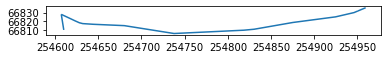

In [50]:
geom = []
links = []

first_node = path[0]
for node in path[1:]:
    link_fid = g.edges[first_node, node]['fid']
    links.append(link_fid)
    row = path_network.loc[path_network['gml_id'] == link_fid]
    geom.append(row['geometry'].cascaded_union)
    first_node = node

path_gpd = gpd.GeoDataFrame({'fid': links, 'geometry': geom})
path_gpd.plot()

## Plotting

In [51]:
back_array = sheepstor_map.read(1)
palette = np.array([value for key, value in sheepstor_map.colormap(1).items()])
background_image = palette[back_array]
bounds = sheepstor_map.bounds
extent = (bounds.left, bounds.right, bounds.bottom, bounds.top)

C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:2: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  
C:\Users\User\anaconda3\envs\ATN_Devon\lib\site-packages\ipykernel_launcher.py:9: UserWarning: The default value for the *approx* keyword argument to OSGB will change from True to False after 0.18.
  if __name__ == '__main__':


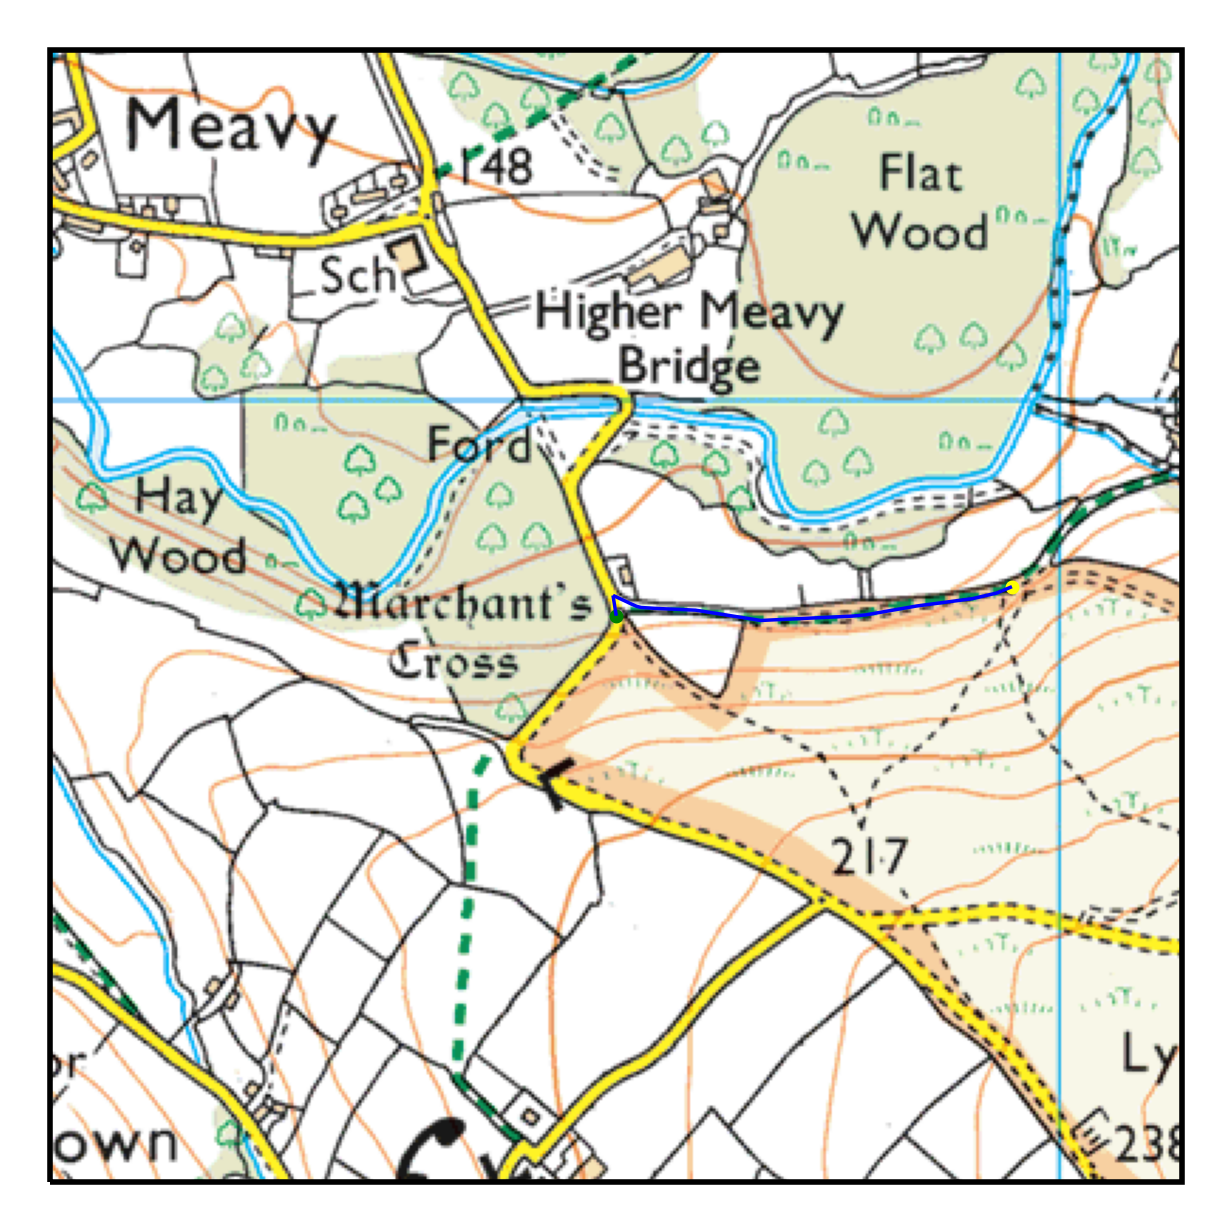

In [52]:
fig = plt.figure(figsize=(3, 3), dpi=500)
ax = fig.add_subplot(1, 1, 1, projection=crs.OSGB())
ax.imshow(background_image, origin='upper', extent=extent, zorder=0)
plt.scatter(first_coordinate[0], first_coordinate[1], color='green', s=1, zorder=4)
plt.scatter(last_coordinate[0], last_coordinate[1], color='yellow', s=1, zorder=4)
path_gpd.plot(ax=ax, edgecolor='blue', linewidth=0.5, zorder=5)
display_extent = ((first_coordinate[0] - 500, first_coordinate[0] + 500,
                          first_coordinate[1] - 500, first_coordinate[1] + 500))
ax.set_extent(display_extent,crs=crs.OSGB())
plt.show()